<a href="https://colab.research.google.com/github/msmsriram/BIGDATA_ANALYTICS_FACE_BOOK_DATA/blob/main/SENTIMENT_ANALYSIS_BD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317145 sha256=d91983715b642247d143dfeec84945435fe8b8cf35cbd3618fb1ec3c5cccfcb0
  Stored in directory: /root/.cache/pip/wheels/9f/34/a4/159aa12d0a510d5ff7c8f0220abbea42e5d81ecf588c4fd884
Successfully built pyspark


In [ ]:
from IPython import display
import math
import pandas as pd
import numpy as np

from pyspark.sql import SQLContext
from pyspark import SparkContext

from pyspark.sql.types import *

In [ ]:
sc =SparkContext()
sqlContext = SQLContext(sc)

/usr/local/lib/python3.9/dist-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [ ]:
customSchema = StructType([
    StructField("clean_text", StringType()),
    StructField("category", StringType())])

In [ ]:
filename1 = '/content/Twitter_Data.csv'

filename2 = '/content/Reddit_Data.csv'

In [ ]:
df1 = sqlContext.read.format("csv").option("header", "true").schema(customSchema).load(filename1)
df1.count()

192131

In [ ]:
df2 = sqlContext.read.format("csv").option("header", "true").schema(customSchema).load(filename2)
df2.count()

38305

In [ ]:
df = df1.union(df2)#, emp_acc_LoadCsvDF("acc_id").equalTo(emp_info_LoadCsvDF("info_id")), "inner").selectExpr("acc_id", "name", "salary", "dept_id", "phone", "address", "email")
df.count()

230436

In [ ]:
data = df.na.drop(how='any')
data.show(5)

+--------------------+--------+
|          clean_text|category|
+--------------------+--------+
|when modi promise...|      -1|
|talk all the nons...|       0|
|what did just say...|       1|
|asking his suppor...|       1|
|answer who among ...|       1|
+--------------------+--------+
only showing top 5 rows



In [ ]:
df.count()

230436

In [ ]:
data.printSchema()

root
 |-- clean_text: string (nullable = true)
 |-- category: string (nullable = true)



In [ ]:
from pyspark.sql.functions import col

data.groupBy("category").count().orderBy(col("count").desc()).show()

+--------+-----+
|category|count|
+--------+-----+
|       1|86224|
|       0|66446|
|      -1|42908|
+--------+-----+



#Model Pipeline
regexTokenizer: Tokenization (with Regular Expression)

stopwordsRemover: Remove Stop Words

countVectors: Count vectors (“document-term vectors”)

In [ ]:
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml.classification import LogisticRegression

# regular expression tokenizer
regexTokenizer = RegexTokenizer(inputCol="clean_text", outputCol="words", pattern="\\W")

# stop words
add_stopwords = ["http","https","amp","rt","t","c","the"]

stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered").setStopWords(add_stopwords)

# bag of words count
countVectors = CountVectorizer(inputCol="filtered", outputCol="features", vocabSize=30000, minDF=5)

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
label_stringIdx = StringIndexer(inputCol = "category", outputCol = "label")

pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, countVectors, label_stringIdx])

# Fit the pipeline to training documents.
pipelineFit = pipeline.fit(data)
dataset = pipelineFit.transform(data)
dataset.show(5)


+--------------------+--------+--------------------+--------------------+--------------------+-----+
|          clean_text|category|               words|            filtered|            features|label|
+--------------------+--------+--------------------+--------------------+--------------------+-----+
|when modi promise...|      -1|[when, modi, prom...|[when, modi, prom...|(24654,[0,1,7,30,...|  2.0|
|talk all the nons...|       0|[talk, all, the, ...|[talk, all, nonse...|(24654,[0,1,2,8,1...|  1.0|
|what did just say...|       1|[what, did, just,...|[what, did, just,...|(24654,[0,2,3,20,...|  0.0|
|asking his suppor...|       1|[asking, his, sup...|[asking, his, sup...|(24654,[0,6,7,8,1...|  0.0|
|answer who among ...|       1|[answer, who, amo...|[answer, who, amo...|(24654,[0,22,69,1...|  0.0|
+--------------------+--------+--------------------+--------------------+--------------------+-----+
only showing top 5 rows



#Partition Training & Test sets

In [ ]:
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed = 100)
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))

Training Dataset Count: 136811
Test Dataset Count: 58767


#Model Training and Evaluation

In [ ]:
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)
lrModel = lr.fit(trainingData)

predictions = lrModel.transform(testData)

predictions.filter(predictions['prediction'] == 0).select("clean_text","category","probability","label","prediction")\
.orderBy("probability", ascending=False).show(n = 10, truncate = 30)

+------------------------------+--------+------------------------------+-----+----------+
|                    clean_text|category|                   probability|label|prediction|
+------------------------------+--------+------------------------------+-----+----------+
| just shut and follow ikeda...|       1|[0.9999999997595463,1.56086...|  0.0|       0.0|
|even the most important peo...|       1|[0.9999999979322731,8.98315...|  0.0|       0.0|
|best news addressed these i...|       1|[0.999999978389196,3.043396...|  0.0|       0.0|
|upa had one the highest gro...|       1|[0.9999999606091137,3.98797...|  0.0|       0.0|
| 006 save mojo 4653 full ep...|       1|[0.9999999028508141,4.19822...|  0.0|       0.0|
| ‘force snapdeal dump aamir...|      -1|[0.999999719540893,1.971494...|  2.0|       0.0|
|not even half brilliant evi...|       1|[0.9999996827315326,5.01054...|  0.0|       0.0|
| posting voter predictions ...|       1|[0.9999993942718627,1.17133...|  0.0|       0.0|
| just goo

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
lrAccuracy = evaluator.evaluate(predictions)
print(lrAccuracy)

0.7635389430397557


In [ ]:
trainingSummary = lrModel.summary

# for multiclass, we can inspect metrics on a per-label basis
print("\nFalse positive rate by label:")
for i, rate in enumerate(trainingSummary.falsePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("\nTrue positive rate by label:")
for i, rate in enumerate(trainingSummary.truePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("\nPrecision by label:")
for i, prec in enumerate(trainingSummary.precisionByLabel):
    print("label %d: %s" % (i, prec))

print("\nRecall by label:")
for i, rec in enumerate(trainingSummary.recallByLabel):
    print("label %d: %s" % (i, rec))

print("\nF-measure by label:")
for i, f in enumerate(trainingSummary.fMeasureByLabel()):
    print("label %d: %s" % (i, f))

accuracy = trainingSummary.accuracy
falsePositiveRate = trainingSummary.weightedFalsePositiveRate
truePositiveRate = trainingSummary.weightedTruePositiveRate
fMeasure = trainingSummary.weightedFMeasure()
precision = trainingSummary.weightedPrecision
recall = trainingSummary.weightedRecall
print("\nAccuracy: %s\n\nFPR: %s\n\nTPR: %s\n\nF-measure: %s\n\nPrecision: %s\n\nRecall: %s"
      % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))


False positive rate by label:
label 0: 0.09672817694019108
label 1: 0.12477475983594778
label 2: 0.007297218813522805

True positive rate by label:
label 0: 0.9032631910067714
label 1: 0.9424404556437694
label 2: 0.6358373810632777

Precision by label:
label 0: 0.8806921822789714
label 1: 0.7946735551472595
label 2: 0.960836559247901

Recall by label:
label 0: 0.9032631910067714
label 1: 0.9424404556437694
label 2: 0.6358373810632777

F-measure by label:
label 0: 0.8918348998774008
label 1: 0.8622721395931822
label 2: 0.7652605657770926

Accuracy: 0.8577819035019114

FPR: 0.08658205909157304

TPR: 0.8577819035019114

F-measure: 0.8540099852208223

Precision: 0.8691568837877899

Recall: 0.8577819035019114


#Logistic Regression using TF-IDF Features

In [ ]:
from pyspark.ml.feature import HashingTF, IDF

hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=30000)
idf = IDF(inputCol="rawFeatures", outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms
pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, hashingTF, idf, label_stringIdx])

pipelineFit = pipeline.fit(data)
dataset = pipelineFit.transform(data)

(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed = 100)
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)
lrModel = lr.fit(trainingData)

predictions = lrModel.transform(testData)

predictions.filter(predictions['prediction'] == 0) \
    .select("clean_text","category","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+------------------------------+--------+------------------------------+-----+----------+
|                    clean_text|category|                   probability|label|prediction|
+------------------------------+--------+------------------------------+-----+----------+
| just shut and follow ikeda...|       1|[0.9999999999956422,6.79768...|  0.0|       0.0|
|even the most important peo...|       1|[0.9999999966676953,1.28149...|  0.0|       0.0|
|upa had one the highest gro...|       1|[0.9999999964287811,1.76005...|  0.0|       0.0|
|best news addressed these i...|       1|[0.9999999870287959,2.86825...|  0.0|       0.0|
| modi’ government last four...|       1|[0.9999999462160947,3.05575...|  0.0|       0.0|
|not even half brilliant evi...|       1|[0.9999999013842449,1.95817...|  0.0|       0.0|
| 006 save mojo 4653 full ep...|       1|[0.9999998747268489,4.59142...|  0.0|       0.0|
|thanks for doing this ama t...|       1|[0.9999998420152606,3.15519...|  0.0|       0.0|
| very int

In [ ]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

0.7379194858251854

#Cross-Validation

In [ ]:
pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, countVectors, label_stringIdx])

pipelineFit = pipeline.fit(data)
dataset = pipelineFit.transform(data)
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed = 100)

lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)


In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.1, 0.3, 0.5]) # regularization parameter
             .addGrid(lr.elasticNetParam, [0.0, 0.1, 0.2]) # Elastic Net Parameter (Ridge = 0)
#            .addGrid(model.maxIter, [10, 20, 50]) #Number of iterations
#            .addGrid(idf.numFeatures, [10, 100, 1000]) # Number of features
             .build())

# Create 5-fold CrossValidator
cv = CrossValidator(estimator=lr, \
                    estimatorParamMaps=paramGrid, \
                    evaluator=evaluator, \
                    numFolds=5)

cvModel = cv.fit(trainingData)

predictions = cvModel.transform(testData)
# Evaluate best model
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

0.8216800367152399

#Naive Bayes

In [ ]:
from pyspark.ml.classification import NaiveBayes
nb = NaiveBayes(smoothing=1)
nbModel = nb.fit(trainingData)
predictions = nbModel.transform(testData)
predictions.filter(predictions['prediction'] == 0) \
    .select("clean_text","category","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+------------------------------+--------+------------------------------+-----+----------+
|                    clean_text|category|                   probability|label|prediction|
+------------------------------+--------+------------------------------+-----+----------+
|respected sir sar and madam...|       1|[1.0,3.945173214204318E-18,...|  0.0|       0.0|
|respected sir sar and madam...|       1|[1.0,1.3028075269905147E-18...|  0.0|       0.0|
|respected sir sar and madam...|       1|[1.0,3.398139781643675E-21,...|  0.0|       0.0|
|respected sir sar and madam...|       1|[1.0,1.0489765997755373E-21...|  0.0|       0.0|
| things opinion most likely...|       1|[1.0,6.567869835075215E-30,...|  0.0|       0.0|
|the team has list the free ...|       1|[1.0,3.464936394451876E-31,...|  0.0|       0.0|
| list the free encyclopedia...|       1|[1.0,1.9059931751739877E-33...|  0.0|       0.0|
|donating blood the free enc...|       1|[1.0,1.575793672102376E-34,...|  0.0|       0.0|
|also why 

In [ ]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
nbAccuracy = evaluator.evaluate(predictions)
print(nbAccuracy)

0.7639990400037707


#DecisionTreeClassifier

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(trainingData)
predictions = dtModel.transform(testData)
predictions.filter(predictions['prediction'] == 0) \
    .select("clean_text","category","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+------------------------------+--------+------------------------------+-----+----------+
|                    clean_text|category|                   probability|label|prediction|
+------------------------------+--------+------------------------------+-----+----------+
| imran khan and modi who be...|       1|[0.9018935683969964,0.01762...|  0.0|       0.0|
| admit ’ problem but ’ glob...|       1|[0.9018935683969964,0.01762...|  0.0|       0.0|
| joke the day have the abil...|       1|[0.9018935683969964,0.01762...|  0.0|       0.0|
| don really listen indian s...|       1|[0.9018935683969964,0.01762...|  0.0|       0.0|
| 100 kim rockhyun nominated...|       1|[0.9018935683969964,0.01762...|  0.0|       0.0|
| also think lot about palad...|       1|[0.9018935683969964,0.01762...|  0.0|       0.0|
|2014 election bjp aap 329 a...|       1|[0.9018935683969964,0.01762...|  0.0|       0.0|
| and hamare desh right wing...|       1|[0.9018935683969964,0.01762...|  0.0|       0.0|
|aap too g

In [ ]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
dtAccuracy = evaluator.evaluate(predictions)
print(dtAccuracy)


0.2693168540063872


#Random Forest

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="label", \
                            featuresCol="features", \
                            numTrees = 100, \
                            maxDepth = 4, \
                            maxBins = 32)
# Train model with Training Data
rfModel = rf.fit(trainingData)
predictions = rfModel.transform(testData)
predictions.filter(predictions['prediction'] == 0) \
    .select("clean_text","category","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+------------------------------+--------+------------------------------+-----+----------+
|                    clean_text|category|                   probability|label|prediction|
+------------------------------+--------+------------------------------+-----+----------+
|brilliant point point break...|       1|[0.5968296777029294,0.15197...|  0.0|       0.0|
| just shut and follow ikeda...|       1|[0.5891102257063635,0.18993...|  0.0|       0.0|
|you are simpleton and have ...|       1|[0.5861334592479711,0.16154...|  0.0|       0.0|
|the limits acceptable disco...|       1|[0.5748986505311924,0.17579...|  0.0|       0.0|
| women rights this needs ma...|       1|[0.565415884137297,0.184015...|  0.0|       0.0|
|they are the textbook defin...|       1|[0.564376538150664,0.210291...|  0.0|       0.0|
|upa was good maybe even mar...|       1|[0.5616921698727282,0.19050...|  0.0|       0.0|
|hello have few questions re...|       1|[0.55759347993791,0.1927853...|  0.0|       0.0|
|not even 

In [ ]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
rfAccuracy = evaluator.evaluate(predictions)
print(rfAccuracy)

0.2682815706404554


#OnevsRest classifer

In [ ]:
from pyspark.ml.classification import LogisticRegression, OneVsRest

lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)

ovr = OneVsRest(classifier=lr)

ovrModel = ovr.fit(trainingData)

# score the model on test data.
predictions = ovrModel.transform(testData)

predictions.filter(predictions['prediction'] == 0) \
    .select("clean_text","category","label","prediction") \
    .show(n = 10, truncate = 30)

+------------------------------+--------+-----+----------+
|                    clean_text|category|label|prediction|
+------------------------------+--------+-----+----------+
| abuser modi bhakth just as...|       0|  1.0|       0.0|
| after grand success coffee...|       1|  0.0|       0.0|
| also fuel for mahagathband...|       1|  0.0|       0.0|
| breaking india shoots down...|       1|  0.0|       0.0|
| cant hate modi without lov...|      -1|  2.0|       0.0|
| congratulations the entire...|       1|  0.0|       0.0|
| cool down chowkidar relax ...|       1|  0.0|       0.0|
| desperation win shows surv...|       1|  0.0|       0.0|
| dont believe modi will spa...|       1|  0.0|       0.0|
| gadkari only has hold vidh...|       1|  0.0|       0.0|
+------------------------------+--------+-----+----------+
only showing top 10 rows



In [ ]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
ovrAccuracy = evaluator.evaluate(predictions)
print(ovrAccuracy)

0.7385231768767154


#Visualization

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
model = ['Logistic regression', 'Naive Bayes', 'Random Forest', 'OneVsRest']
accuracy = [lrAccuracy,nbAccuracy,rfAccuracy, ovrAccuracy]

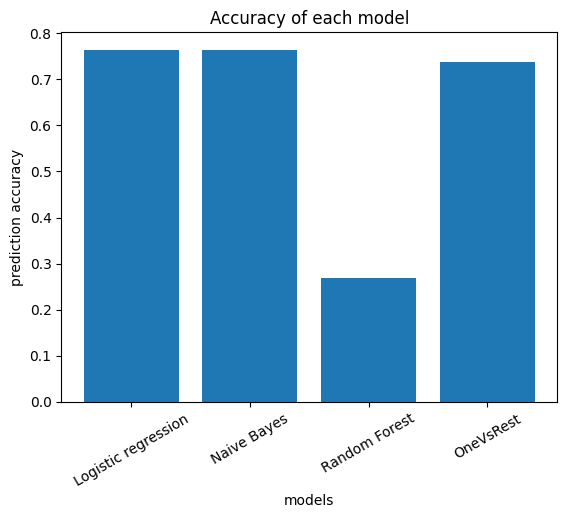

In [ ]:
def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len(model))
    plt.bar(index, accuracy)
    plt.xlabel('models', fontsize=10)
    plt.ylabel('prediction accuracy', fontsize=10)
    plt.xticks(index, model, fontsize=10, rotation=30)
    plt.title('Accuracy of each model')
    plt.show()

plot_bar_x()